In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [163]:
#from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
#from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

In [139]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# DATA

In [24]:
pfeStock = pd.read_csv("EOD-PFE.csv").iloc[::-1,0:5]
koStock = pd.read_csv("EOD-KO.csv").iloc[::-1,0:5]
msftStock = pd.read_csv("EOD-MSFT.csv").iloc[::-1,0:5]
wmtStock = pd.read_csv("EOD-WMT.csv").iloc[::-1,0:5]
baStock = pd.read_csv("EOD-BA.csv").iloc[::-1,0:5]

sliding data:
- Turns time series data to a format we can use with classification models.  
- column 5 is the latest closing price 
- would use column 5 as our y(training label)

In [67]:
def getSlidingData(data, column, windowSize):
    shape = data.shape
    formatted = []
    for i in range(0,shape[0]-windowSize):
        formatted.append(data.iloc[i:i+windowSize, column].tolist())
    formatted = pd.DataFrame(formatted)
    return formatted

In [70]:
formattedPfe = getSlidingData(pfeStock, 4, 6)
formattedPfe.head() 

,0,1,2,3,4,5
0,28.01,28.37,28.27,28.28,28.30,28.45
1,28.37,28.27,28.28,28.30,28.45,28.67
2,28.27,28.28,28.30,28.45,28.67,28.31
3,28.28,28.30,28.45,28.67,28.31,28.51
4,28.30,28.45,28.67,28.31,28.51,28.71


percent changes:
- another way to represent stock data
- already normalized form
- mean of 0 and variance around it 

In [30]:
def getPercentages(data, column):
    shape = data.shape
    newindex = range(0,shape[0]-2)
    price1 = np.array(data.iloc[0:shape[0]-2, column].tolist())
    price2 = np.array(data.iloc[1:shape[0]-1, column].tolist())

    percentage = price1 - price2 
    percentage *= (100/price2)
    percentage = pd.DataFrame([newindex, percentage.tolist()]).T
    
    return percentage

In [75]:
percentPfe = getPercentages(pfeStock, 4)
percentPfe.head()

,0,1
0,0.0,-1.268946
1,1.0,0.353732
2,2.0,-0.035361
3,3.0,-0.070671
4,4.0,-0.527241


In [77]:
formattedPPfe = getSlidingData(percentPfe, 1, 6)
formattedPPfe.head()

,0,1,2,3,4,5
0,-1.268946,0.353732,-0.035361,-0.070671,-0.527241,-0.767353
1,0.353732,-0.035361,-0.070671,-0.527241,-0.767353,1.271635
2,-0.035361,-0.070671,-0.527241,-0.767353,1.271635,-0.701508
3,-0.070671,-0.527241,-0.767353,1.271635,-0.701508,-0.696621
4,-0.527241,-0.767353,1.271635,-0.701508,-0.696621,0.244413


# VISUALIZING DATA

overall comments
- left is daily closing price, right is daily percent change of price
- closing price trends upwards
- percent change is quite erratic

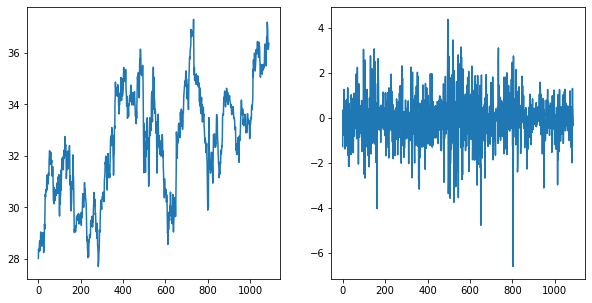

In [59]:
plt.figure(figsize=(10, 5))

mashY1 = pfeStock.iloc[0:1091,4].tolist()
plt.subplot(1,2,1)
plt.plot(range(0,1090),mashY1)

mashY2 = getPercentages(pfeStock, 4).iloc[:,1]
plt.subplot(1,2,2)
plt.plot(range(0,1088),mashY2)

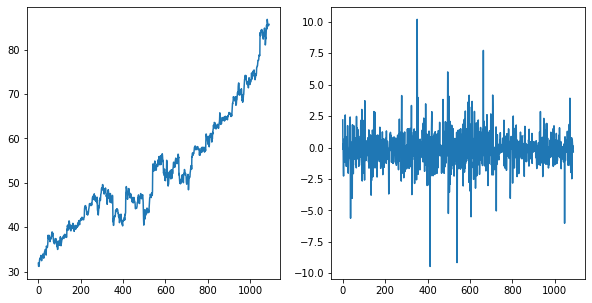

In [57]:
plt.figure(figsize=(10, 5))

mashY1 = msftStock.iloc[0:1091,4].tolist()
plt.subplot(1,2,1)
plt.plot(range(0,1090),mashY1)

mashY2 = getPercentages(msftStock, 4).iloc[:,1]
plt.subplot(1,2,2)
plt.plot(range(0,1088),mashY2)

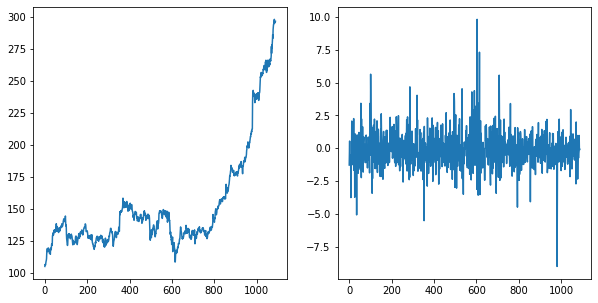

In [56]:
plt.figure(figsize=(10, 5))

mashY1 = baStock.iloc[0:1091,4].tolist()
plt.subplot(1,2,1)
plt.plot(range(0,1090),mashY1)

mashY2 = getPercentages(baStock, 4).iloc[:,1]
plt.subplot(1,2,2)
plt.plot(range(0,1088),mashY2)

# MULTI-VARIATE LINEAR REGRESSION

Idea:
- each of the days in the N-window are given a weight 
- which day is most impactful

In [78]:
# Multivariate-Linear Regression using closing prices
regLin = LinearRegression().fit(formattedPfe.iloc[0:1000,0:5], formattedPfe.iloc[0:1000,5])
score = regLin.score(formattedPfe.iloc[1000:1084,0:5], formattedPfe.iloc[1000:1084,5])
print("Score ", score, "\n",
      "Actual ", formattedPfe.iloc[1000:1004,5].tolist(), "\n",
      "Predicted ", regLin.predict(formattedPfe.iloc[1000:1004,0:5]), "\n")

Score  0.862007801841695 
 Actual  [33.5, 33.45, 33.92, 33.96] 
 Predicted  [33.44444576 33.4878379  33.42226551 33.92916163] 



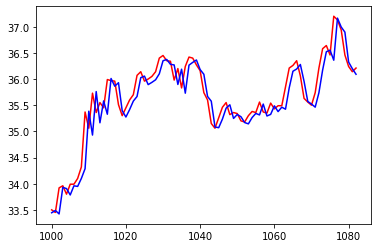

In [82]:
# Predicted Prices
mashY = formattedPfe.iloc[0:1000,5].tolist() + regLin.predict(formattedPfe.iloc[1000:1083,0:5]).tolist()
plt.plot(range(1000,1083), formattedPfe.iloc[1000:1083,5].tolist(), color='r')
plt.plot(range(1000,1083), regLin.predict(formattedPfe.iloc[1000:1083,0:5]).tolist(), color='b')

In [86]:
# Multivariate-Linear Regression using closing percent changes
regLin = LinearRegression().fit(formattedPPfe.iloc[0:1000,0:5], formattedPPfe.iloc[0:1000,5])
score = regLin.score(formattedPPfe.iloc[1000:1083,0:5], formattedPPfe.iloc[1000:1083,5])
print("Score ", score, "\n",
      "Actual ", formattedPPfe.iloc[1000:1004,5].tolist(), "\n",
      "Predicted ", regLin.predict(formattedPPfe.iloc[1000:1004,0:5]), "\n")

Score  -0.08229055701000942 
 Actual  [0.14947683109117235, -1.3856132075471665, -0.11778563015311881, 0.4733727810650998] 
 Predicted  [-0.02205661  0.03763326 -0.09920231  0.0763739 ] 



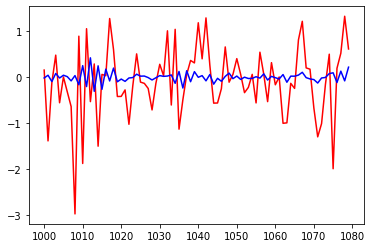

In [88]:
# Predicted Prices
mashY = formattedPPfe.iloc[0:1000,5].tolist() + regLin.predict(formattedPPfe.iloc[1000:1083,0:5]).tolist()
plt.plot(range(1000,1080), formattedPPfe.iloc[1000:1080,5].tolist(), color='r')
plt.plot(range(1000,1080), regLin.predict(formattedPPfe.iloc[1000:1080,0:5]).tolist(), color='b')

# Multi-Layer Perceptron Regression

Idea:
- each neurons can learn significant N-window trends

Note:
scaled stock prices to between 0 and 1 to normalize
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029

In [214]:
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='relu'))
mlp.add(Dense(25, activation='relu'))
mlp.add(Dense(10, activation='relu'))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

mlp.fit(set_scaled.iloc[0:1000,0:5], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(set_scaled.iloc[1000:1083,0:5], set_scaled.iloc[1000:1083,5])
print('Performance: ', eval)

83/83 [==============================] - 0s 43us/step
Performance:  [0.0008066633256174714, 0.0008066633017733693]


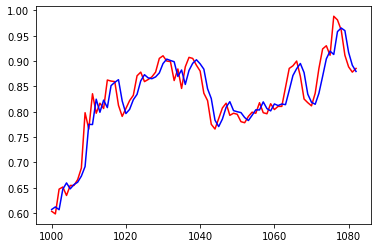

In [215]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = mlp.predict(set_scaled.iloc[1000:1083,0:5])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [216]:
input_shape = (5,)

mlp = Sequential()
mlp.add(Dense(50, input_shape=input_shape, activation='relu'))
mlp.add(Dense(25,  activation='relu'))
mlp.add(Dense(10, activation='relu'))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

mlp.fit(formattedPPfe.iloc[0:1000,0:5], formattedPPfe.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(formattedPPfe.iloc[1000:1083,0:5], formattedPPfe.iloc[1000:1083,5])
print('Performance: ', eval[1])

82/82 [==============================] - 0s 30us/step
Accuracy for MLP:  0.6088739633560181


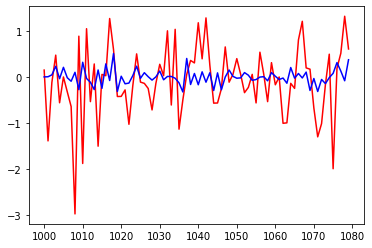

In [217]:
real = formattedPPfe.iloc[1000:1080,5].tolist()
predict = mlp.predict(formattedPPfe.iloc[1000:1080,0:5])
plt.plot(range(1000,1080), real, color='r')
plt.plot(range(1000,1080), predict, color='b')

# Recurrent Neural Network

rnn:
- made for time series data

Note:
scaled stock prices to between 0 and 1 to normalize
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029

In [257]:
rnn = Sequential()
rnn.add(LSTM(units=50,return_sequences=True,input_shape = (5,1)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=10,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=5))
rnn.add(Dense(1, activation='linear'))
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

sc = MinMaxScaler(feature_range=(0,1))
set_scaled = sc.fit_transform(formattedPfe)
set_scaled = pd.DataFrame(set_scaled)

xInput = np.array(formattedPfe.iloc[0:1083,0:5])
xInput = np.reshape(xInput, (xInput.shape[0], xInput.shape[1], 1))
rnn.fit(xInput[0:1000], set_scaled.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = rnn.evaluate(xInput[1000:1083], set_scaled.iloc[1000:1083,5])
print('Performance: ', eval)

83/83 [==============================] - 0s 176us/step
Performance:  [0.0037130860174186976, 0.003713086014613509]


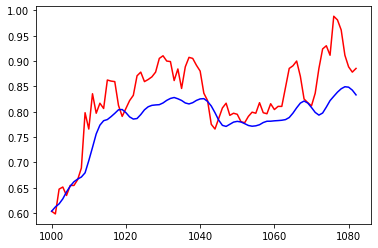

In [258]:
real = set_scaled.iloc[1000:1083,5].tolist()
predict = rnn.predict(xInput[1000:1083])
plt.plot(range(1000,1083), real, color='r')
plt.plot(range(1000,1083), predict, color='b')

In [ ]:
rnn = Sequential()
rnn.add(LSTM(units=50,return_sequences=True,input_shape = (5,1)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=25,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=10,return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=5))
rnn.add(Dense(1, activation='linear'))
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

xInput = np.array(formattedPPfe.iloc[0:1083,0:5])
xInput = np.reshape(xInput, (xInput.shape[0], xInput.shape[1], 1))
rnn.fit(xInput[0:1000], formattedPPfe.iloc[0:1000,5], epochs=15, batch_size=10, verbose=0, validation_split=0.15)
eval = mlp.evaluate(xInput[1000:1083], formattedPPfe.iloc[1000:1083,5])
print('Performance: ', eval[1])

In [ ]:
real = formattedPPfe.iloc[1000:1080,5].tolist()
predict = mlp.predict(xInput[1000:1080,0])
plt.plot(range(1000,1080), real, color='r')
plt.plot(range(1000,1080), predict, color='b')